#Introdução

Nesse projeto, estou usando um dataset do Kaggle de churn em uma academia. Após a análise e preprocessamento, é desenvolvido um modelo que prevê se um determinado cliente abandonará a academia (churn) ou não.

#Imports


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score, roc_auc_score

#Lendo CSV

In [ ]:
df = pd.read_csv('gym_members_dataset.csv')
df.head()

,Member_ID,Name,Age,Gender,Address,Phone_Number,Membership_Type,Join_Date,Last_Visit_Date,Favorite_Exercise,Avg_Workout_Duration_Min,Avg_Calories_Burned,Total_Weight_Lifted_kg,Visits_Per_Month,Churn
0,1,NaN,19.0,Male,"Street 171, City 39",032-51510359,Quarterly,2022-07-23,2022-11-03,Pull-ups,93,214.0,13995.0,18.0,No
1,2,Shanza,19.0,Female,"Street 111, City 18",039-19243328,Monthly,2023-12-04,2024-02-14,Squats,37,436.0,4612.0,11.0,No
2,3,Ubaidullah,52.0,Male,"Street 69, City 21",033-60221501,Quarterly,2024-09-13,2024-12-07,Bench Press,98,523.0,3124.0,4.0,Yes
3,4,Mansoor Ahmed,52.0,Male,"Street 72, City 39",035-55527902,Monthly,2024-06-05,2025-02-24,Pull-ups,66,282.0,4586.0,24.0,No
4,5,Hanzala,32.0,Male,"Street 6, City 12",038-93946322,Monthly,2022-06-15,2022-12-02,Bench Press,32,522.0,16353.0,18.0,No


###Legenda dos dados

* Member_ID: Identificador único de cada membro.
* Name: Nome anonimizado.
* Age / Gender / Address / Phone_Number: Informações demográficas básicas.
* Membership_Type: Tipo de plano (Mensal, Trimestral ou Anual).
* Join_Date / Last_Visit_Date: datas de matrícula e última visita.
* Favorite_Exercise: Exercício ou atividade preferido na academia.
* Avg_Workout_Duration_Min: Tempo médio gasto por treino.
* Avg_Calories_Burned: Calorias estimadas queimadas por treino.
* Total_Weight_Lifted_kg: Peso total levantado nos treinos.
* Visits_Per_Month: Média de visitas à academia por mês.
* **Churn**: *Variável alvo*. Indica se um membro parou de frequentar (Sim ou Não).


#Análise exploratória

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Member_ID                 150 non-null    int64  
 1   Name                      127 non-null    object 
 2   Age                       137 non-null    float64
 3   Gender                    150 non-null    object 
 4   Address                   150 non-null    object 
 5   Phone_Number              150 non-null    object 
 6   Membership_Type           150 non-null    object 
 7   Join_Date                 141 non-null    object 
 8   Last_Visit_Date           150 non-null    object 
 9   Favorite_Exercise         150 non-null    object 
 10  Avg_Workout_Duration_Min  150 non-null    int64  
 11  Avg_Calories_Burned       139 non-null    float64
 12  Total_Weight_Lifted_kg    142 non-null    float64
 13  Visits_Per_Month          138 non-null    float64
 14  Churn     

In [ ]:
df.describe()

,Member_ID,Age,Avg_Workout_Duration_Min,Avg_Calories_Burned,Total_Weight_Lifted_kg,Visits_Per_Month
count,150.000000,137.000000,150.000000,139.000000,142.000000,138.000000
mean,75.500000,35.905109,73.326667,488.309353,9486.978873,14.224638
std,43.445368,11.654892,25.879560,168.649317,5127.955128,6.385451
min,1.000000,18.000000,30.000000,209.000000,1009.000000,4.000000
25%,38.250000,25.000000,53.000000,341.500000,5274.000000,8.000000
50%,75.500000,36.000000,74.000000,496.000000,9072.500000,14.000000
75%,112.750000,46.000000,94.500000,627.500000,13620.750000,20.000000
max,150.000000,54.000000,119.000000,788.000000,19722.000000,24.000000


In [ ]:
df_plot = df.copy()
columns_to_remove = ['Member_ID', 'Name', 'Address', 'Phone_Number', 'Join_Date', 'Last_Visit_Date']

df_plot = df_plot.drop(columns_to_remove, axis=1)

df_plot['Age'] = df_plot['Age'].fillna(df_plot['Age'].median())
df_plot['Avg_Calories_Burned'] = df_plot['Avg_Calories_Burned'].fillna(df_plot['Avg_Calories_Burned'].median())
df_plot['Total_Weight_Lifted_kg'] = df_plot['Total_Weight_Lifted_kg'].fillna(df_plot['Total_Weight_Lifted_kg'].median())
df_plot['Visits_Per_Month'] = df_plot['Visits_Per_Month'].fillna(df_plot['Visits_Per_Month'].median())
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       150 non-null    float64
 1   Gender                    150 non-null    object 
 2   Membership_Type           150 non-null    object 
 3   Favorite_Exercise         150 non-null    object 
 4   Avg_Workout_Duration_Min  150 non-null    int64  
 5   Avg_Calories_Burned       150 non-null    float64
 6   Total_Weight_Lifted_kg    150 non-null    float64
 7   Visits_Per_Month          150 non-null    float64
 8   Churn                     150 non-null    object 
dtypes: float64(4), int64(1), object(4)
memory usage: 10.7+ KB


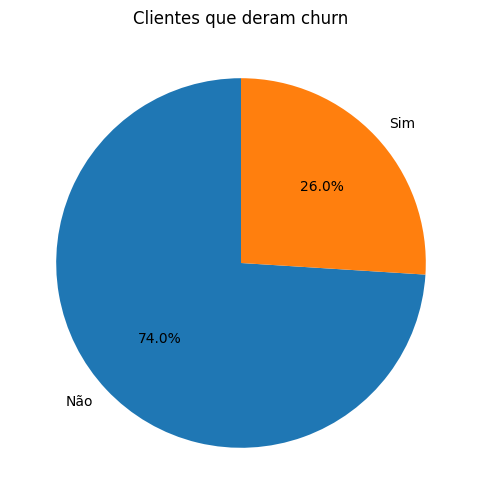

In [ ]:
plt.figure(figsize=(10,6))

contagem = df_plot['Churn'].value_counts()
nomes = {'Yes': 'Sim', 'No': 'Não'}
plt.pie(
    contagem,
    startangle=90,
    labels=[nomes.get(label, label) for label in contagem.index],
    autopct='%1.1f%%'
)
plt.title('Clientes que deram churn')

plt.show()

<Figure size 1200x600 with 0 Axes>

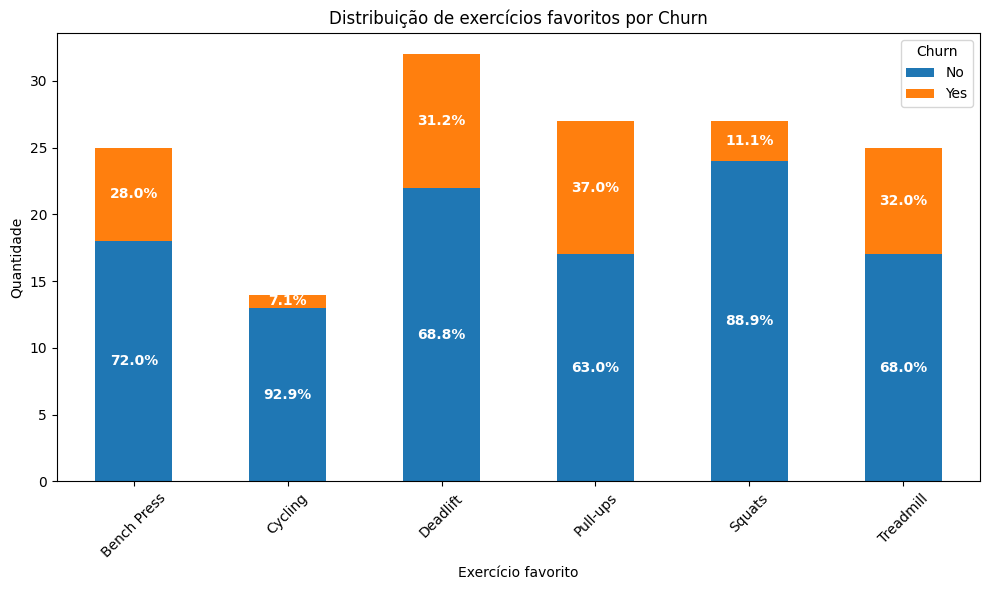

In [ ]:
tabela = df_plot.pivot_table(
    index='Favorite_Exercise',
    columns='Churn',
    aggfunc='size',
    fill_value=0
)

plt.figure(figsize=(12,6))

ax = tabela.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=['#1f77b4', '#ff7f0e']
)

plt.title('Distribuição de exercícios favoritos por Churn')
plt.xlabel('Exercício favorito')
plt.ylabel('Quantidade')
plt.legend(title='Churn')
plt.xticks(rotation=45)
plt.tight_layout()

for i, fav in enumerate(tabela.index):
    total = tabela.loc[fav].sum()

    acumulado = 0
    for churn in tabela.columns:
        valor = tabela.loc[fav, churn]

        if valor > 0:
            porcentagem = (valor / total) * 100
            ax.text(
                x=i,
                y=acumulado + valor/2,
                s=f"{porcentagem:.1f}%",
                ha='center',
                va='center',
                fontsize=10,
                color='white',
                fontweight='bold'
            )

        acumulado += valor

plt.show()

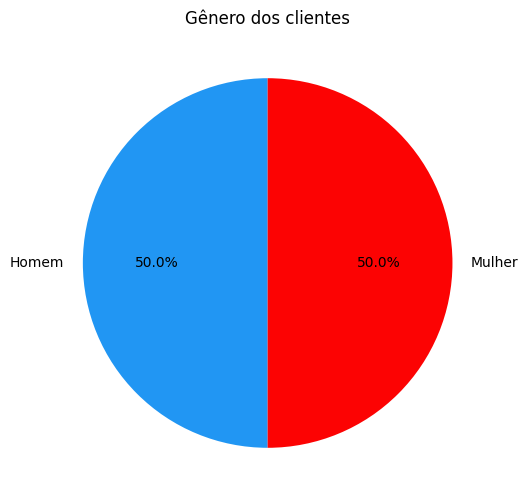

In [ ]:
plt.figure(figsize=(10,6))

contagem = df_plot['Gender'].value_counts()
nomes = {'Female': 'Mulher', 'Male': 'Homem'}
plt.pie(
    contagem,
    startangle=90,
    labels=[nomes.get(label, label) for label in contagem.index],
    autopct='%1.1f%%',
    colors=['#2196F3', '#fc0303']
)
plt.title('Gênero dos clientes')

plt.show()

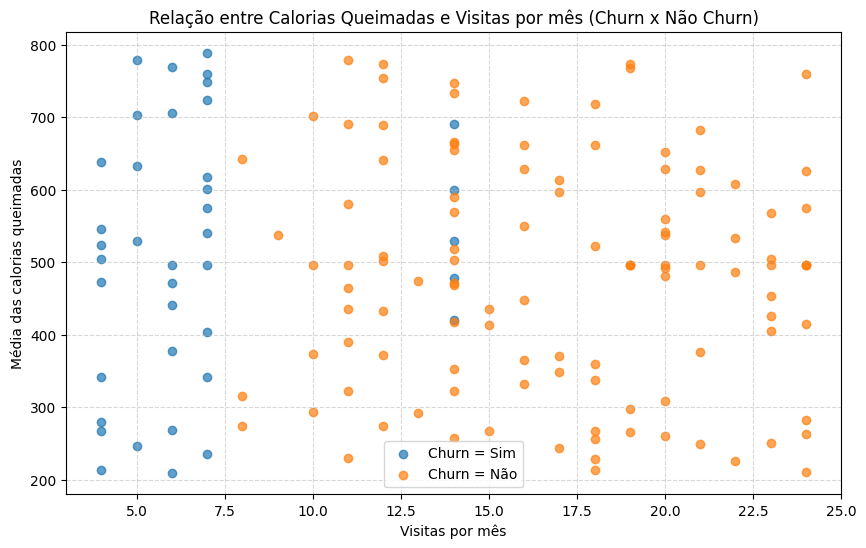

In [ ]:
plt.figure(figsize=(10,6))

df_yes = df_plot[df_plot['Churn'] == 'Yes']
df_no = df_plot[df_plot['Churn'] == 'No']

plt.scatter(df_yes['Visits_Per_Month'], df_yes['Avg_Calories_Burned'],
            label='Churn = Sim', alpha=0.7)

plt.scatter(df_no['Visits_Per_Month'], df_no['Avg_Calories_Burned'],
            label='Churn = Não', alpha=0.7)

plt.xlabel('Visitas por mês')
plt.ylabel('Média das calorias queimadas')
plt.title('Relação entre Calorias Queimadas e Visitas por mês (Churn x Não Churn)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [ ]:
columns_ohe = ['Membership_Type', 'Favorite_Exercise']
columns_dummy = ['Gender']

df_encoded = pd.get_dummies(df_plot, columns=['Membership_Type', 'Favorite_Exercise'])
df_encoded['Gender'] = df_encoded['Gender'].map({'Male': 0, 'Female': 1})
df_encoded['Churn'] = df_encoded['Churn'].map({'No': 0, 'Yes': 1})

df_encoded

,Age,Gender,Avg_Workout_Duration_Min,Avg_Calories_Burned,Total_Weight_Lifted_kg,Visits_Per_Month,Churn,Membership_Type_Monthly,Membership_Type_Quarterly,Membership_Type_Yearly,Favorite_Exercise_Bench Press,Favorite_Exercise_Cycling,Favorite_Exercise_Deadlift,Favorite_Exercise_Pull-ups,Favorite_Exercise_Squats,Favorite_Exercise_Treadmill
0,19.0,0,93,214.0,13995.0,18.0,0,False,True,False,False,False,False,True,False,False
1,19.0,1,37,436.0,4612.0,11.0,0,True,False,False,False,False,False,False,True,False
2,52.0,0,98,523.0,3124.0,4.0,1,False,True,False,True,False,False,False,False,False
3,52.0,0,66,282.0,4586.0,24.0,0,True,False,False,False,False,False,True,False,False
4,32.0,0,32,522.0,16353.0,18.0,0,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,54.0,0,64,733.0,6082.0,14.0,0,False,True,False,False,False,False,True,False,False
146,45.0,1,95,641.0,7375.0,12.0,0,True,False,False,True,False,False,False,False,False
147,54.0,0,80,471.0,6138.0,14.0,0,False,True,False,False,False,True,False,False,False
148,26.0,1,50,473.0,18336.0,4.0,1,True,False,False,True,False,False,False,False,False


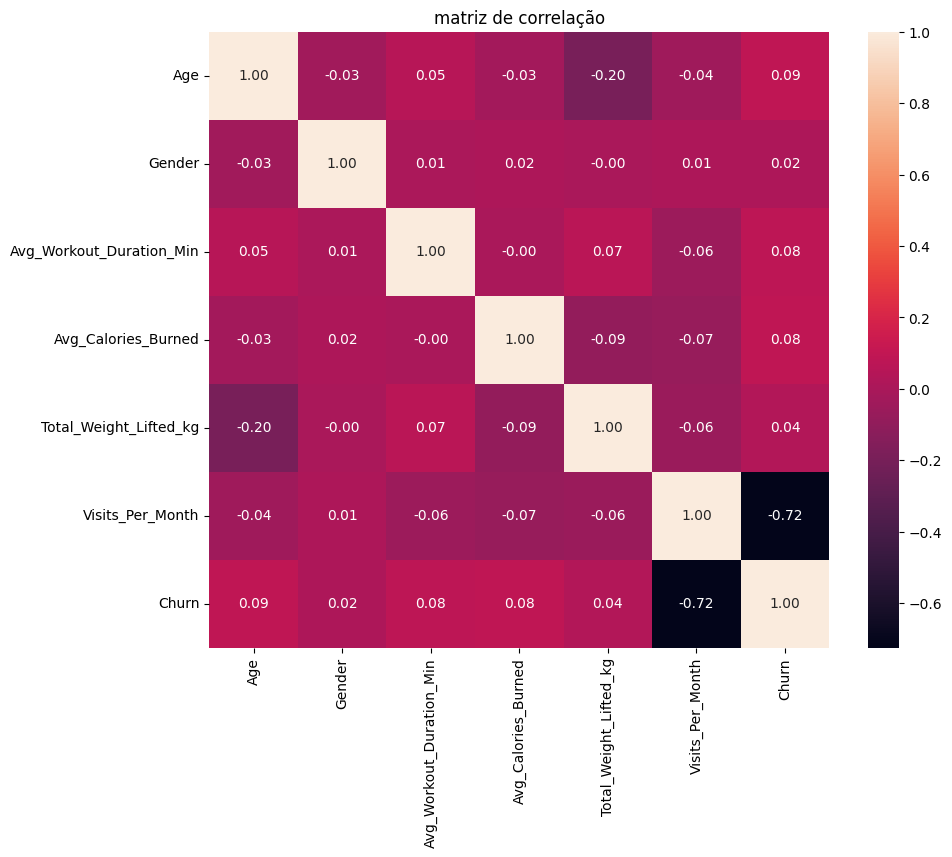

In [ ]:
df_numerico_refac = df_encoded.select_dtypes(include=['number'])
corr_matrix = df_numerico_refac.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("matriz de correlação")
plt.ylabel("")
plt.xlabel("")
plt.show()

Com a análise dos dados acima, adquirimos algumas informações importantes:

*   o gênero está balanceado mas o Churn não.
*   Mesmo pull-ups não sendo o exercício favorito dos usuários, ele apresenta maior percentual de Churn que os outros.
*   Não é possível identificar um relação direta entre o gasto calórico médio e o Churn
*   Todos os clientes com menos de 10 visitas mensais desistiram da academia o que demonstra uma relação direta entre Churn e visitas.
*   A variável que apresenta maior relação direta com churn é a quantidade de visitas no mês, sendo as pessoas que foram menos no mês mais propensas a abandonarem o plano da academia.

#Divisão Treino e teste

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

y = y.map({'No': 0, 'Yes': 1})
X['Gender'] = X['Gender'].map({'Male': 0, 'Female': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X train: {X_train.shape}')
print(f'y train: {y_train.shape}')
print(f'X test: {X_test.shape}')
print(f'y test: {y_test.shape}')
X_train.head()

X train: (120, 14)
y train: (120,)
X test: (30, 14)
y test: (30,)


,Member_ID,Name,Age,Gender,Address,Phone_Number,Membership_Type,Join_Date,Last_Visit_Date,Favorite_Exercise,Avg_Workout_Duration_Min,Avg_Calories_Burned,Total_Weight_Lifted_kg,Visits_Per_Month
22,23,Aena,20.0,1,"Street 63, City 26",032-48189951,Yearly,2024-04-29,2024-07-30,Pull-ups,47,625.0,8994.0,24.0
15,16,Laraib,49.0,1,"Street 8, City 38",033-94385113,Quarterly,2024-01-12,2024-03-02,Treadmill,86,542.0,11803.0,20.0
65,66,Saad Ali,53.0,0,"Street 42, City 4",037-27967661,Quarterly,2022-07-08,2022-07-27,Deadlift,104,404.0,5576.0,7.0
11,12,Hammad Arif,22.0,0,"Street 188, City 37",037-79862568,Quarterly,2022-10-10,2023-04-05,Deadlift,77,529.0,9532.0,5.0
42,43,Maryam,42.0,1,"Street 68, City 37",033-48288721,Monthly,2024-06-26,2024-07-04,Deadlift,43,263.0,4829.0,24.0


#Construção da pipeline

In [ ]:
columns_to_remove = ['Member_ID', 'Name', 'Address', 'Phone_Number', 'Join_Date', 'Last_Visit_Date']
columns_median = ['Age', 'Visits_Per_Month', 'Total_Weight_Lifted_kg', 'Avg_Calories_Burned']
columns_encoder = ['Membership_Type', 'Favorite_Exercise']

pre = ColumnTransformer([
  ('drop_cols', 'drop', columns_to_remove),
  ('num', SimpleImputer(strategy='median'), columns_median),
  ('cat', OneHotEncoder(handle_unknown='ignore'), columns_encoder)
])

In [ ]:
pipe = Pipeline([
  ('prep', pre),
  ('scaler', StandardScaler(with_mean=False)),
  ('smote', SMOTE()),
  ('pca', PCA(n_components=9)),
  ('clf', XGBClassifier())
])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('drop_cols', 'drop',
                                                  ['Member_ID', 'Name',
                                                   'Address', 'Phone_Number',
                                                   'Join_Date',
                                                   'Last_Visit_Date']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'Visits_Per_Month',
                                                   'Total_Weight_Lifted_kg',
                                                   'Avg_Calories_Burned']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Membership_Type',
                                                   'Favorite_Exercis...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
pca = pipe.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
cumulative_variance = pca.explained_variance_ratio_.cumsum()

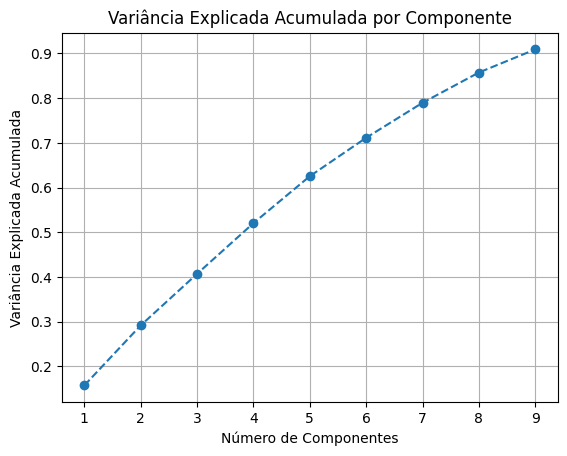

In [ ]:
plt.plot(range(1, 10), cumulative_variance, marker='o', linestyle='--')
plt.title('Variância Explicada Acumulada por Componente')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)
plt.show()

In [ ]:
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    error_score='raise'
)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

Para a construção desse modelo foi utilizado o pipeline do sklearn para deixar mais organizado o processo e evitar *data leaks*. Dessa forma, o desenvolvimento do modelo ocorreu da seguinte forma:

1.   Pré processamento: Aqui as colunas que não eram interessantes para o modelo como nome, endereço, telefone, foram removidas. Depois, os valores nulos das colunas numéricas foram substituidos pela mediana e por ultimo, as colunas categóricas foram codificadas.

2.   Padronização: Os valores das colunas numéricas foram padronizadas (média 0 e desvio padrão 1) para ajustar as diferentes escalas das colunas melhorando a performance do modelo.

3.   Balanceamento: Nessa etapa os dados da coluna alvo (Churn) são igualados em quantidade de valores (50% sim, 50% não) para evitar que o modelo fique enviesado apenas pelos valores que mais aparecem.

4.   PCA: Essa tecnica é utilizada para reduzir a quantidade de variáveis, usando apenas as que possuem maior relação com o Churn. Foi elaborado um gráfico para testar diferentes valores até chegar na quantidade que explique, pelo menos, 90% da variância. Esse valor encontrado foi o de 9, significando que 9 variáveis apenas foram utilizadas e que as outras foram ignoradas no treinamento do modelo, diminuindo sua complexidade e melhorando acurácia.

5.  Grid Search: Método para ajustar os hiperparâmetros do modelo, buscando a melhor combinação que resulte em uma acurácia maior.

6.   Treinamento: Etapa final do processo, onde os dados já tratados e ajustados com todas as técnicas acima são usados no treinamento do modelo.



#Avaliação

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print("ROC-AUC:", roc_auc)
print('Relatório de Classificação:')
print(report)

Acurácia: 0.8666666666666667
ROC-AUC: 0.8295454545454545
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.75      0.75      0.75         8

    accuracy                           0.87        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.87      0.87      0.87        30



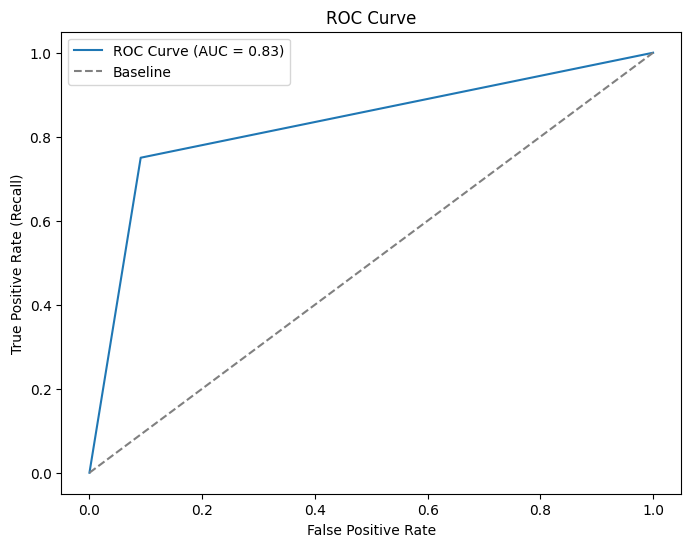

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Baseline")
plt.fill_between(fpr, tpr, fpr, where=(tpr > fpr), alpha=0.3)

plt.xlabel("Falso Positivo")
plt.ylabel("verdadeiro Positivo (Recall)")
plt.title("Curva ROC")
plt.legend()
plt.show()

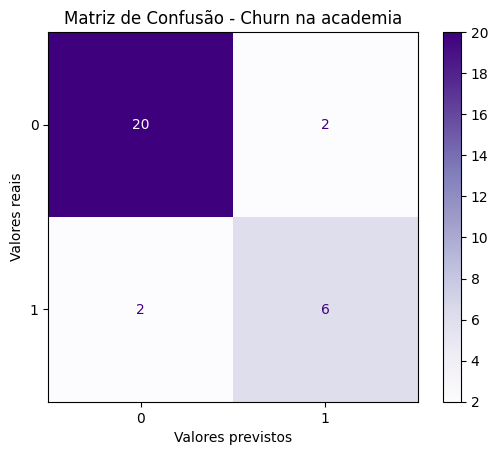

In [ ]:
cm_logis = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_logis, display_labels=[0, 1])
disp.plot(cmap="Purples")
plt.title("Matriz de Confusão - Churn na academia")
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.show()

O modelo apresenta um desempenho muito bom com acurácia de 0.86 porém, como o dataset apresenta uma quantidade pequena de cadastros (150), o treino e o teste apresentam variações elevadas a cada novo treino. A matrix de confusão demonstra um bom desempenho do modelo na detecção de casos onde o Churn é 'Não', mas precisa ser melhorado na detecção de Churn 'Sim'. Essa acurácia baixa recai ao problema comentado acima de um dataset muito curto.